# PID Controller Simulation

## Leaning Objectives

After completing this exercise, the student will be able to:
- Create a simple model for a PID controller (**Exercise 1**,**Exercise 2**)
- Numerically integrate and differentiate the motion of a moving body (**Exercise 2**)
- Implement and analyze the effects of an integral and derivative term on the system response (**Exercise 2**)
- (Bonus) Explore how a more complex system affects the PID controller's behavior (**Exercise 3**)

## Introduction
Small drones are now a part of everything from warehouse automation to aerial photography. Keeping them stable in the air is crucial to their success. Suppose we want to keep one exactly 10 meters above the ground. This seems easy — just apply enough thrust to counteract gravity, right?

But how do we know how much thrust to apply? And what if the environment isn't still? A gust of wind could push the drone up or down, and we need to adjust the thrust accordingly. How do we do that smoothly, and without the drone oscillating up and down?

This is a common problem in <a href="https://en.wikipedia.org/wiki/Control_theory">Control theory</a>. To keep the drone flying steadily at the right height, we need a way to adjust how much thrust force to apply. One method for doing this is by using a **PID controller**. PID stands for Proportional, Integral, and Derivative, and it is a type of feedback controller that figures out how much thrust to apply based on how far the drone is from the target height.

It does this by looking at three things:
1. **Proportional (P)**: How far is the drone from the desired height right now? If it is too low, increase thrust. If it is too high, reduce thrust.
2. **Integral (I)**: Has the drone been off target for a while? If it has been too low for a long time, gradually increase thrust to correct for that. This helps remove any steady offset.
3. **Derivative (D)**: How fast is the height changing? If the drone is rising too quickly, reduce thrust to prevent overshooting. If it is falling quickly, increase the thrust to slow the descent.
                       
The only things the PID controller needs to know are the true height of the drone and the target height. It continuously compares the two to calculate the difference between them, known as the **error**, and then uses the P, I and D components to decide how much thrust to apply.

In this project, we will simulate a one-dimensional PID controller that attempts to keep a drone stable at a desired height. We will explore how the different components of the PID controller affect the response and see how a seemingly simple feedback loop can yield powerful control behavior.

## 1. Visualizing the system
Before we can simulate the PID controller, we need to understand the forces acting on the drone. To do this, we will begin by drawing a **free body diagram** to visualize these forces.


### 1 a) Free Body Diagram
Sketch the system and draw a free body diagram of a drone hovering at a target height $h$. Since we are working in one dimension (vertical), horizontal forces can be ignored. The drone is affected by two main forces: gravity, pulling it downward, and thrust, pushing it upward. The thrust force is controlled via the drone’s "gas pedal", which adjusts how much upward force is applied to counteract gravity. 

Draw one free body diagram for a light drone, and one for a heavy drone. What is the difference between the two?

Solution: For a heavier drone, both arrows would need to be longer. The reason for this is that the gravitational force acting on the drone is proportional to its mass. A heavier drone would require more thrust to counteract the increased gravitational force, resulting in arrows in the free body diagram.

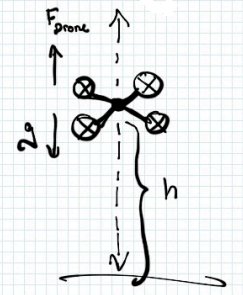



### 1b) Change of forces 

The free body diagrams above describe the drone when it is hovering steadily at the target height $h$, meaning there is a balance between the forces. But what happens when the drone is not at the target height? Are the forces still the same?


**Solution**: No, the forces change depending on the drone's height relative to the target height. If the drone is below the target height, the thrust must be greater than the gravitational force to lift it up. If it is above the target height, the thrust must be less than the gravitational force to allow it to descend. 

## 2. The P Controller

We will start by implementing the proportional (P) component of the PID controller. A proportional controller adjusts its output based on how far the drone is from the target height. Meaning, the larger the difference, the stronger the response.
In our case, the controller output is the thrust force applied to the drone, which we write as a function of time $u(t)$. The error is the difference between the target height and the current height of the drone:
$$
u(t) = K_P e(t)
$$
where $K_P$ is the proportional gain, $e(t)$ is the error at time $t$, and $u(t)$ is the resulting thrust force.

A larger error means more thrust. In this section, we will see how a proportional controller alone affects the drone's motion, and why it is often not enough on its own. 


### 2 a) Finding the acceleration
To simulate the drone's motion, we need to calculate the vertical acceleration. This is done by finding the net force acting on the drone, which is the difference between the thrust force and the gravitational force. The gravitational force is constant and can be represented as $F_g = m \cdot g$, where $m$ is the mass of the drone and $g$ is the acceleration due to gravity (approximately 9.81 m/s²).

Using Newton's second law $F=ma$, express the drone's acceleration $a(t)$ as a function of the thrust force $u(t)$ and the gravitational force $F_g$.


**Solution**: $$ a(t) = \frac{u(t) - F_g}{m} = \frac{u(t) - mg}{m}$$

### 2 b) Implementing the acceleration function

Using the expression for acceleration, implement the function `acceleration(thrust, m, g)` that calculates the vertical acceleration of the drone.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
def acceleration(thrust, m, g):
    """
    Calculates the net vertical acceleration of the drone.
    """
    return (thrust - m * g) / m

### 2 c) The proportional component
Now we have implemented a function for acceleration. But as you can see, the acceleration depends on the thrust force $u(t)$, which we have not yet defined.

In this subsection, we want to implement two more functions:
1. `proportional_component(K_P, error)` that calculates the thrust force $u(t)$ based on the error $e(t)$ and the proportional gain $K_P$.
2. `error(target_height, current_height)` that calculates the error $e(t)$ as the difference between the target height and the current height of the drone.

These are the last two pieces we need to implement the proportional component of the controller.

In [3]:
def calculate_error(target_height, current_height):
    """
    Calculates the difference between the target height and the current height of the drone.
    """
    return target_height - current_height

def proportional_component(K_P, error):
  
    return K_P * error


### 2 d) Simulate the P controller

Now that we have all the pieces, we are ready to simulate the movement of the drone using the proportional controller.

In the following code section, you will implement the Euler-Cromer method to numerically integrate the velocity and position of the drone. The Euler-Cromer method is an extension of the Euler method and is significantly more stable and reliable for simulating physical systems when the acceleration is known.

The Euler-Cromer equations for this system are:

\begin{align*}
    v(t + \Delta t) &= v(t) + a(t) \Delta t\\
    r(t + \Delta t) &= r(t) + v(t + \Delta t) \Delta t
\end{align*}
where $v(t)$ is the velocity at time $t$, $r(t)$ is the position at time $t$, and $\Delta t$ is the time step.

 

In [ ]:
## initialize the system
m = 1.0  # mass
target_height = 10.0 # desired position
start_position = 0.0 # initial position
start_velocity = 0.0 # initial velocity
g = 9.81  # gravitational acceleration
K_P = 5.0  # proportional gain


n = 500
T = np.linspace(0, 20, n)  # time vector
dt = T[1] - T[0]  # time step

position = np.zeros(n)  # position
velocity = np.zeros(n)  # velocity
accelerations = np.zeros(n)  # acceleration
position[0] = start_position  # set initial position
velocity[0] = start_velocity  # set initial velocity


# Euler cromer method for numerical integration
for i in range(1, n):
    # Calculate the control input using the proportional term
    error = calculate_error(target_height, position[i-1])
    thrust = proportional_component(K_P, error)

    # Calculate the acceleration
    accelerations[i] = acceleration(thrust, m, g)

    # Update velocity and position using Euler-Cromer method
    velocity[i] = velocity[i-1] + accelerations[i] * dt
    position[i] = position[i-1] + velocity[i] * dt

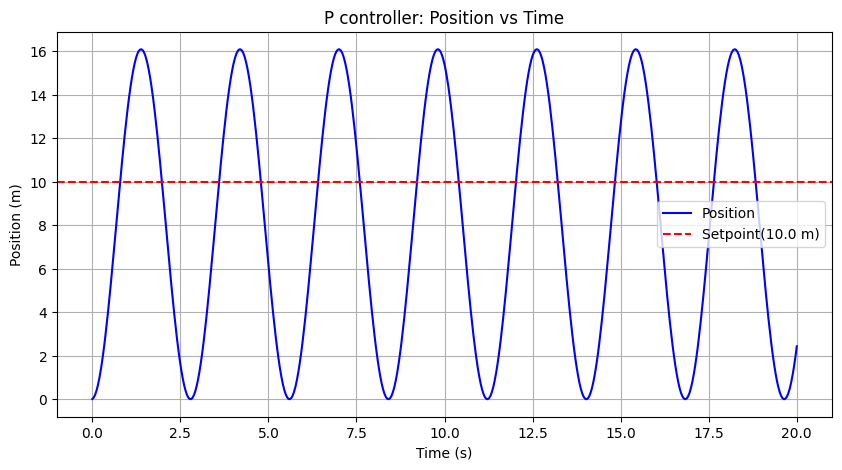

In [ ]:
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(T, position, label='Position', color='blue')
plt.axhline(target_height, color='red', linestyle='--', label=f'Setpoint({target_height} m)')
plt.title('P controller: Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.show()    

Your results might look pretty bad at first, but that is expected. The P controller is not very good at keeping the drone stable. Therefore, the next step is to add the derivative component to the controller.

## 3) PD controller
We have just witnessed the limitations of a P controller. It only reacts to the current error, meaning the difference between the target height and the measurement position, without considering how the error is changing over time. This often leads to overshooting and oscillations in the system.

To improve the controller, we introduce a derivative component, D, which responds to the rate of change of the error. This allows the controller to anticipate where the system is heading, not just where it currently is. In other words, the derivative component acts as anticipatory control, pushing back harder when the error is changing rapidly and backing off when things are stabilizing. It effectively adds damping, which helps smooth out the response and prevent overshooting.

Mathematically, the controller signal is now proportional to both the error and its derivative:
$$u(t) = K_p e(t) + K_D \frac{∂ e(t)}{∂ t}$$

### 3 a) Understanding the derivative component
Before we implement the derivative component, let us first try to understand how it affects the system. The derivative component is the rate of change of the error, which can be approximated by:
$$\frac{∂ e(t)}{∂ t} \approx \frac{e(t) - e(t - \Delta t)}{\Delta t}$$
where $\Delta t$ is the time step, $e(t)$ is the error at time $t$, and $e(t - \Delta t)$ is the error at the previous time step.

Now consider these situations:
1. What happens to the thrust force $u(t)$ when the drone is **below** the target height, but rising quickly?
2. What happens to the thrust force $u(t)$ when the drone is **above** the target height, and falling back towards it?
3. What happens with the thrust force $u(t)$ when the drone is at a **stable** height (not necessarily the target height)?

*Hint: Think about the sign of the error and the sign of its derivative in each case*

**Solution**:
1. The error is positive: $\text{target height} - \text{current height} > 0$, and the derivative is negative: $\frac{∂ e(t)}{∂ t} < 0$. So the P component is positive and the D component is negative. The net effect is that the D component reduces the total thrust compared to the P component alone. It damps the response to avoid overshooting.
2. The error is negative: $\text{target height} - \text{current height} < 0$, and the derivative is positive: $\frac{∂ e(t)}{∂ t} > 0$. So the P component is negative and the D component is positive. The net effect is that the D component counters the P component. The thrust is increased compared to a pure P controller, damping the descent.
3. When the drone is at a stable offset position, the error is constant: $\text{target height} - \text{current height} = C$, where $C$ is a constant. The derivative is zero: $\frac{∂ e(t)}{∂ t} = 0$. So the drone hovers at an offset position where the thrust from the P term alone balances gravity. This is a known limitation of the PD controller. They can not eliminate steady-state errors. 

### 3 b) Implementing the derivative component

The next thing we need to do is to implement the derivative of the error into the simulation. A simple way of calculating the derivative is to use the difference between the current and previous error:
$$\frac{∂ e(t)}{∂ t} = \frac{e(t) - e(t-1)}{Δt}$$

Fill in the function `derivative_component(K_D, error, previous_error, dt)` below.

In [6]:
def derivative_component(K_D, current_error, previous_error, dt):
    """
    Derivative term for a PID controller: K_D ⋅ (∂ e(t))/(∂ t).
    """
    derivative = (current_error - previous_error) / dt
    return K_D * derivative

### 3 c) Simulating the PD controller
Now that you have implemented the derivative component, you are ready to simulate the movement of the drone using the PD controller.

Use the Euler Cromer method to numerically integrate the velocity and position of the drone. The PD controller will use the proportional and derivative components to calculate the thrust force. Also plot the result and observe how it changes compared to the P controller.

In [ ]:
K_P = 5.0  # proportional gain
K_D = 5.0  # derivative gain

position = np.zeros(n)  # position
velocity = np.zeros(n)  # velocity
accelerations = np.zeros(n)  # acceleration
position[0] = start_position  # set initial position
velocity[0] = start_velocity  # set initial velocity

previous_error = calculate_error(target_height, position[0])  # initialize previous error

for i in range(1, n):
    error = calculate_error(target_height, position[i-1])  # calculate error

    # Calculate the control input using the proportional term
    P = proportional_component(K_P, error)

    # Calculate the derivative term
    D = derivative_component(K_D, error, previous_error, dt)

    thrust = P + D # add derivative term to control input

    # Calculate the acceleration
    accelerations[i] = acceleration(thrust, m, g)

    # Update velocity and position using Euler-Cromer method
    velocity[i] = velocity[i-1] + accelerations[i] * dt
    position[i] = position[i-1] + velocity[i] * dt

    previous_error = error  # update previous error for next iteration

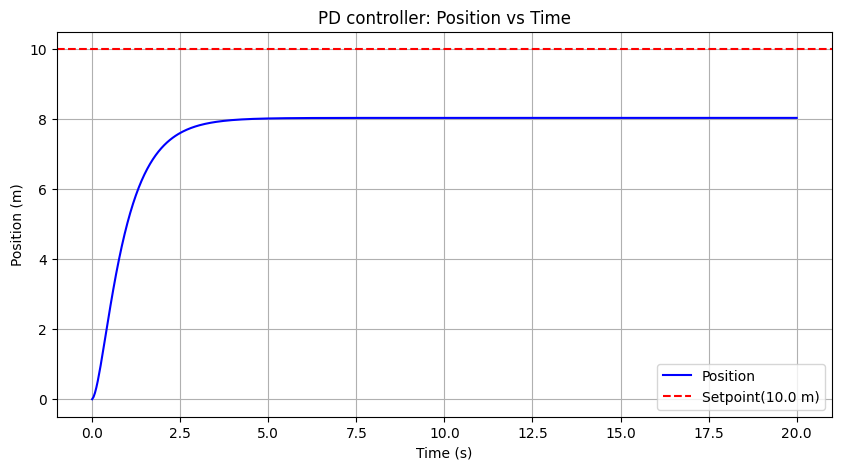

In [ ]:
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(T, position, label='Position', color='blue')
plt.axhline(target_height, color='red', linestyle='--', label=f'Setpoint({target_height} m)')
plt.title('PD controller: Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.show()    

Hopefully, you have now seen an improvement in the stability of the drone. The PD controller is much better at keeping the drone stable than when we only had the P controller. But we can still see that we are not quite there yet. Again, do not worry, we will improve the controller once again by adding the integral term.

## 4) PID controller
We have now seen the effects of the P and D terms in the controller. While the derivative term helps by anticipating changes in error and damping the system response, the PD controller is still not perfect—particularly when it comes to eliminating steady-state errors, where the drone hovers at a height that is not exactly the desired height

To address this problem, we will introduce the integral term, I. The integral term accumulates the error over time, effectively "remembering" past errors. If there is any persistent difference between the target and the measurement, the integral term will continue to grow, pushing the controller to adjust the output until the error is eliminated. This cumulative effect is what allows the controller to eliminate residual or static errors that the proportional term alone cannot handle.

As the error decreases, the contribution from the proportional term naturally weakens, but the integral term, having built up over time, continues to drive the output until the error is zero. Once the error reaches zero, the integral term stops growing, stabilizing the system.

Together, the three terms combine into a PID controller, which is defined as follows:

$$u(t) = K_P e(t) + K_I \int_0^t e(t) dt + K_D \frac{∂ e(t)}{∂ t} $$

### 4 a) Implementing the integral component

We want to implement the integral of the error into the simulation by using a simple numerical integration method, such as a Riemann sum:
$$\int_0^t e(t) dt \approx \sum_{i=0}^{n} e(t_i) \Delta t$$
The Riemann sum will be accumulated in a variable, which needs to be initialized as zero, and then updated in each iteration of the simulation loop.

Fill in the function `integration_component(K_I, Riemann_sum)` below. 

In [9]:
def integration_component(K_I, Riemann_sum):
    """
    Integral term for a PID controller: K_I ⋅ ∑ e(t)⋅Δt
    """
    return K_I * Riemann_sum

### 4 b) Simulating the PID controller

Now that you have implemented all the necessary functions for the PID controller, you should be able to simulate the drone’s movement using the PID controller combined with the Euler Cromer method.

In [ ]:
K_P = 10.0  # proportional gain
K_D = 5.0   # derivative gain
K_I = 5.0  # integral gain

position = np.zeros(n)  # position
velocity = np.zeros(n)  # velocity
accelerations = np.zeros(n)  # acceleration
position[0] = start_position  # set initial position
velocity[0] = start_velocity  # set initial velocity

previous_error = calculate_error(target_height, position[0])  # initialize previous error
Riemann_sum = 0.0  # initialize Riemann sum for integral term

for i in range(1, n):
    # Calculate the error
    error = calculate_error(target_height, position[i-1])
    # Update accumulated error for integral term
    Riemann_sum = Riemann_sum + error * dt  # Riemann sum approximation

    # Calculate the control input using the proportional term
    P = proportional_component(K_P, error)

    # Calculate the derivative term
    D = derivative_component(K_D, error, previous_error, dt)

    # Calculate the integral term
    I = integration_component(K_I, Riemann_sum)

    thrust = P + I + D  # add the components

    # Calculate the acceleration
    accelerations[i] = acceleration(thrust, m, g)

    # Update velocity and position using Euler-Cromer method
    velocity[i] = velocity[i-1] + accelerations[i] * dt
    position[i] = position[i-1] + velocity[i] * dt

    previous_error = error  # update previous error for next iteration

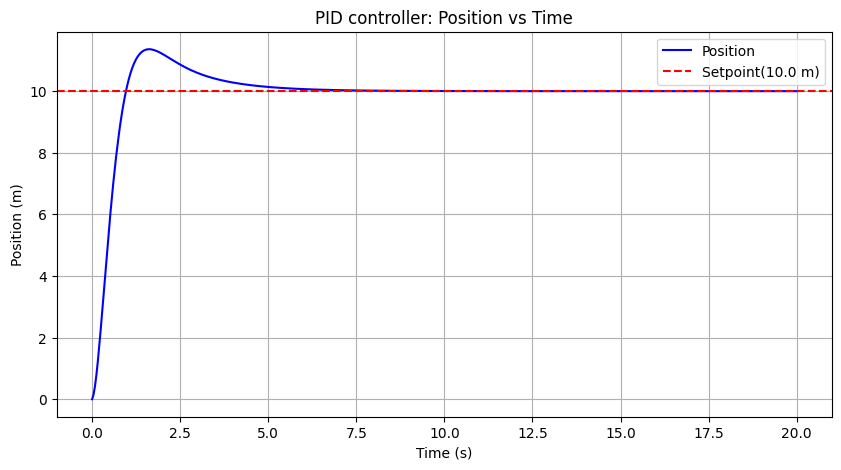

In [ ]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(T, position, label='Position', color='blue')
plt.axhline(target_height, color='red', linestyle='--', label=f'Setpoint({target_height} m)')
plt.title('PID controller: Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.show()

Hopefully, you have now seen a significant improvement in the drone’s stability. Your PID controller should be able to keep the drone steady at the target height.

Now, try adjusting the gains $K_P$, $K_I$, and $K_D$ to see how they affect the system’s response. You can also experiment with changing the target height and observe how the controller reacts to different desired altitudes.



## 5. Add random effects
In the real world, there are often random effects that can affect the stability of the drone. For example, wind gusts can push the drone up or down, and we need to adjust the thrust accordingly. In this exercise, we will add a random effect to the simulation to see how the PID controller reacts to it.

We have created a few example functions to simulate the effects listed below. Try implementing them in your simulation to see how the PID controller reacts. You can also create your own random effects and observe the controller’s response.
### Examples: 
- Wind gusts
- Air resistance
- Moving target position

### 5 a) Free body diagram with random effects
Before you implement the effects, you should first draw a free body diagram of the drone with the random effects you want to explore. How do these effects change the forces acting on the drone, and how do they affect the thrust force that the PID controller needs to apply?

*place your free body diagram here*

In [12]:
def drag_force(v, drag_coeff):
    """
    Calculates the drag force acting on the drone.
    """
    return -drag_coeff * v

def wind_force(wind_amplitude):
    """
    Randomly generates a wind
    """
    return np.random.uniform(-wind_amplitude, wind_amplitude)



In [13]:


K_P = 10.0  # proportional gain
K_D = 10.0   # derivative gain
K_I = 10.0   # integral gain

# Simulate the system with external forces
position = np.zeros(n)  # position
velocity = np.zeros(n)  # velocity
accelerations = np.zeros(n)  # acceleration
position[0] = start_position  # set initial position
velocity[0] = start_velocity  # set initial velocity


previous_error = calculate_error(setpoint, position[0])  # initialize previous error
Riemann_sum = 0.0  # initialize Riemann sum for integral term

for i in range(1, n):
    # Calculate the error
    error = calculate_error(setpoint, position[i-1])
    # Update Riemann sum for integral term
    Riemann_sum = Riemann_sum + error * dt  # Riemann

    # Calculate the control input using the proportional term
    P = proportional_component(K_P, error)

    # Calculate the derivative term
    D = derivative_component(K_D, error, previous_error, dt)

    # Calculate the integral term
    I = integration_component(K_I, Riemann_sum)

    thrust = P + I + D 

    # Calculate the acceleration
    accelerations[i] = acceleration(thrust, m, g)
    accelerations[i] =  accelerations[i] + (wind_force(wind_amplitude=5) + drag_force(velocity[i-1], drag_coeff=1))  / m  # add external forces

    # Update velocity and position using Euler-Cromer method
    velocity[i] = velocity[i-1] + accelerations[i] * dt
    position[i] = position[i-1] + velocity[i] * dt

    previous_error = error  # update previous error for next iteration

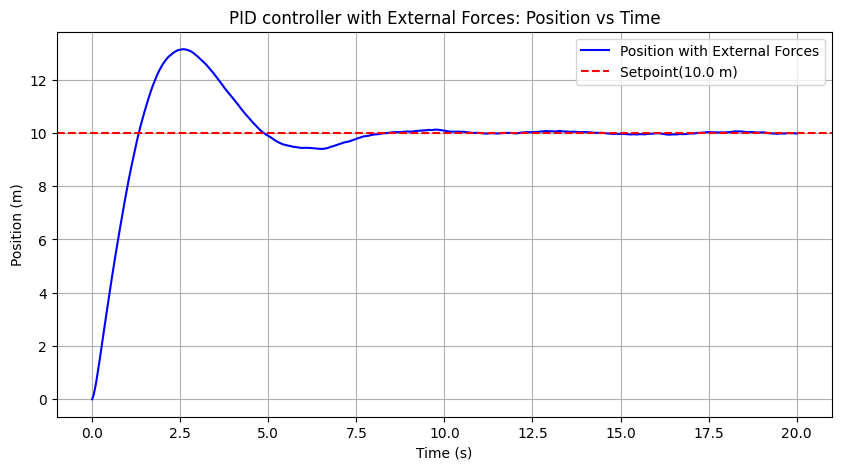

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(T, position, label='Position with External Forces', color='blue')
plt.axhline(setpoint, color='red', linestyle='--', label=f'Setpoint({setpoint} m)')
plt.title('PID controller with External Forces: Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.show()

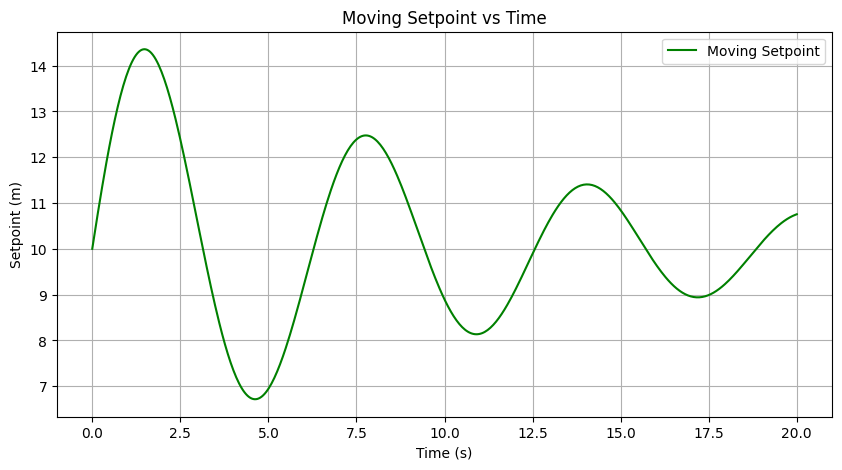

In [15]:
## Moving setpoint
def moving_setpoint(t):
    """
    Example function of a moving setpoint that changes over time.

    Parameters:
    t (float): Current time.

    Returns:
    float: Setpoint value at time t.
    """
    return 10.0 + 5.0 * np.sin(1.0 * t) * np.exp(-0.09 * t)

#plot the moving setpoint
moving_setpoints = moving_setpoint(T)
plt.figure(figsize=(10, 5))
plt.plot(T, moving_setpoints, label='Moving Setpoint', color='green')
plt.title('Moving Setpoint vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Setpoint (m)')
plt.legend()
plt.grid()
plt.show()

In [16]:


K_P = 10.0  # proportional gain
K_D = 10.0   # derivative gain
K_I = 10.0   # integral gain

# Simulate the system with external forces
position = np.zeros(n)  # position
velocity = np.zeros(n)  # velocity
accelerations = np.zeros(n)  # acceleration
position[0] = start_position  # set initial position
velocity[0] = start_velocity  # set initial velocity


previous_error = calculate_error(moving_setpoints[0], position[0])  # initialize previous error
Riemann_sum = 0.0  # initialize Riemann sum for integral term

for i in range(1, n):
    # Calculate the error
    error = calculate_error(moving_setpoints[i], position[i-1])
    
    Riemann_sum = Riemann_sum + error * dt  # Riemann sum approximation

    # Calculate the control input using the proportional term
    P = proportional_component(K_P, error)

    # Calculate the derivative term
    D = derivative_component(K_D, error, previous_error, dt)

    # Calculate the integral term
    I = integration_component(K_I, Riemann_sum)

    thrust = P + I + D

    # Calculate the acceleration
    accelerations[i] = acceleration(thrust, m, g)
    accelerations[i] += (wind_force(wind_amplitude=5) + drag_force(velocity[i-1], drag_coeff=1))  / m  # add external forces

    # Update velocity and position using Euler-Cromer method
    velocity[i] = velocity[i-1] + accelerations[i] * dt
    position[i] = position[i-1] + velocity[i] * dt

    previous_error = error  # update previous error for next iteration

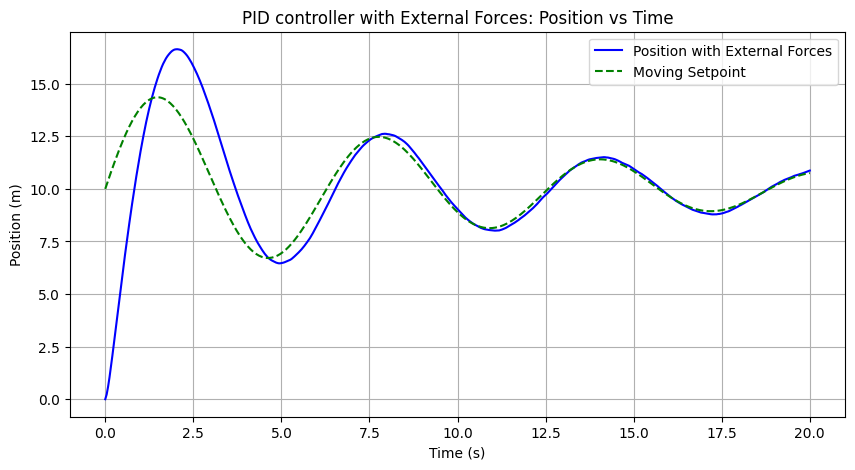

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(T, position, label='Position with External Forces', color='blue')
plt.plot(T, moving_setpoints, label='Moving Setpoint', color='green', linestyle='--')
plt.title('PID controller with External Forces: Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.show()